# Covid-19 Death rate for each of the US states
<sup>By Ramin Madarshahian</sup>

In this work I want to see if there is any relatonship between a state feathers and the death rate from coronavirus. Ideally I liked to make an hierarchical Bayesian model, if I had information of each individuals. Here I don't have those information, but I was thinking maybe I can use state's features to see if they can help to predict the mortality rate of confirmed cases? The feature data are not the most correlated ones, and also in this model I didn't consider sensoring effect. Because we may have some confirmed cases which lead to death but at this moment that indevitual is still alive (and I pray he stays alive). The main goal of this work was to only starting a model which could be an inspiration for others to make better models.
I emphasis the mortality rate is obtained by this work is not nessarily a correct one. This work is only supposed to be an inspiration for much better work of me or other researchers.
## Data prepration
Data are devided into two parts. 
* Coronavirus counter data
* Features of each state
Ideally one can replace these features by other features (hopefully more predictive ones) or data for other countries, or change the model with more complicated one.
### Coronavirus data
The data for infected individuals are updated depends the day one run the code. The source of data is [The Center for Systems Science and Engineering (CSSE) at JHU](https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_daily_reports). Since the data gets updated each day, the results may change by time.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import theano as th
from datetime import date,timedelta
last_updated_date = date.today()
delta = timedelta(days=1)
import requests
base_url =  'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/'
url = base_url+last_updated_date.strftime("%m-%d-%Y")+'.csv'
while requests.get(url).status_code==404:
    last_updated_date-=delta
    url = base_url+last_updated_date.strftime("%m-%d-%Y")+'.csv'
print("last updated file found in %s"%last_updated_date)
    
df = pd.read_csv(url,index_col=0,parse_dates=[0])

last updated file found in 2020-03-29


In [2]:
df_usa_raw = df[df["Country_Region"]=="US"]
df_usa=df_usa_raw.drop(columns=['Admin2','Country_Region', 'Last_Update', 'Lat','Long_','Active','Recovered'])
df_usa_states_raw = df_usa.groupby('Province_State').sum()
df_usa_states_raw=df_usa_states_raw.sort_values('Province_State')
df_usa_states =df_usa_states_raw.drop(index=['Grand Princess','Diamond Princess','District of Columbia','Northern Mariana Islands',\
                                             'Recovered','American Samoa','Virgin Islands','Guam','Puerto Rico','Virgin Islands'])

### Features
Data are downloaded from [Data USA](https://datausa.io/) website. Data are in two excell files and need some cleaning:
* Data of previous years are removed and the last year data, which here is 2018, are included only. 
* I scaled data between zero and one to be abale to compare effect of each.
* I slected these features:
 * Adult smoking - As an indicator of public health
 * High School Graduation - As an indicator of state eduacation
 * Median Houshold Income - As an indicator of wellfare
 * Unemployment - As an indicator of healthy economy
 * Adult Obesity - As an indicator of public health
 * Air pollution - As an indicator of environmental conditions
 * Average age - Since it is claimed age is important. Still I am not sure if it means we have more senior citizens or not?

In [3]:
raw_feature_1 = pd.read_csv(r"C:\Users\madar\Desktop\corona\DataUSA01.csv")
raw_feature_2 = pd.read_csv(r"C:\Users\madar\Desktop\corona\DataUSA02.csv")

In [4]:
raw_feature = raw_feature_1.merge(raw_feature_2)
needed_features = ['Geography', 'Adult Smoking (2018)', 'High School Graduation (2018)',
       'Median Household Income (2018)', 'Unemployment (2018)',
       'Adult Obesity (2018)', 'Air Pollution (2018)', 'Average Age (2018)']
features = raw_feature[needed_features]
features.head()

,Geography,Adult Smoking (2018),High School Graduation (2018),Median Household Income (2018),Unemployment (2018),Adult Obesity (2018),Air Pollution (2018),Average Age (2018)
0,Missouri,0.221377,0.896897,51713,0.045257,0.318,9.5,39.382592
1,Wyoming,0.189463,0.793172,61686,0.052789,0.285,6.5,39.142338
2,Wisconsin,0.170567,0.883857,56808,0.041407,0.306,9.3,39.789277
3,West Virginia,0.248054,0.865104,43175,0.060045,0.355,9.5,41.543068
4,Alabama,0.215382,0.893225,46309,0.059870,0.347,10.1,39.372741


To study the effect of each parameter, I want to put them in the same scale, so data are standardized in range of zero to one.

In [5]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
features_minmax = features.copy()
features_minmax[needed_features[1:]] = min_max_scaler.fit_transform(features_minmax[needed_features[1:]])

and finaly I want to select simpler names for each column

In [6]:
features_minmax.columns

Index(['Geography', 'Adult Smoking (2018)', 'High School Graduation (2018)',
       'Median Household Income (2018)', 'Unemployment (2018)',
       'Adult Obesity (2018)', 'Air Pollution (2018)', 'Average Age (2018)'],
      dtype='object')

In [7]:
new_lable = {'Geography':'state', 'Adult Smoking (2018)':'Smoking', 'High School Graduation (2018)':'education',
       'Median Household Income (2018)':'income', 'Unemployment (2018)':'Unemployment',
       'Adult Obesity (2018)':'Obesity', 'Air Pollution (2018)':'Air_Pollution', 'Average Age (2018)':'Average_Age'}

Feature_cleaned = features_minmax.rename(columns=new_lable)
Feature_cleaned=Feature_cleaned.rename(index=Feature_cleaned['state'])
Feature_cleaned = Feature_cleaned.drop(index='District of Columbia')
Feature_cleaned = Feature_cleaned.sort_index()
Feature_cleaned.columns

Index(['state', 'Smoking', 'education', 'income', 'Unemployment', 'Obesity',
       'Air_Pollution', 'Average_Age'],
      dtype='object')

### Preparing data for the regression model
Now we should match corona virus data, $Y$, of each state to the features, $X$ using a binomial likelihood.

In [8]:
data = df_usa_states.merge(Feature_cleaned,left_index=True,right_index=True)
data_final = data.dropna()
data_final.head()
Y_c = th.shared(data_final['Confirmed'].values)
Y_d = th.shared(data_final['Deaths'].values)
X1 = th.shared(data_final['Smoking'].values)
X2 = th.shared(data_final['education'].values)
X3 = th.shared(data_final['income'].values)
X4 = th.shared(data_final['Unemployment'].values)
X5 = th.shared(data_final['Obesity'].values)
X6 = th.shared(data_final['Air_Pollution'].values)
X7 = th.shared(data_final['Average_Age'].values)

In [9]:
import seaborn as sns
#sns.pairplot(data_final)

## Bayesian binomial regression model
To generate my model I used [PyMC3](https://peerj.com/articles/cs-55/).

In [10]:
import pymc3 as pm

In [11]:
with pm.Model() as model:
    mu_b0= pm.Normal('mu_b0',mu=0,sd=.50)
    sigma_b0= pm.HalfCauchy('sigma_b0', 0.1)
    b0_offset = pm.Normal('b0_offset', mu=0, sd=1)
    b0 = pm.Deterministic("b0", mu_b0 + b0_offset * sigma_b0)
        
    mu_b1= pm.Normal('mu_b1',mu=0,sd=1.0)
    sigma_b1= pm.HalfCauchy('sigma_b1', 0.5)
    b1_offset = pm.Normal('b1_offset', mu=0, sd=1)
    b1 = pm.Deterministic("b1", mu_b1 + b1_offset * sigma_b1)

    mu_b2= pm.Normal('mu_b2',mu=0,sd=1.0)
    sigma_b2= pm.HalfCauchy('sigma_b2', 0.5)
    b2_offset = pm.Normal('b2_offset', mu=0, sd=1)
    b2 = pm.Deterministic("b2", mu_b2 + b2_offset * sigma_b2)

    mu_b3= pm.Normal('mu_b3',mu=0,sd=1.0)
    sigma_b3= pm.HalfCauchy('sigma_b3', 0.5)
    b3_offset = pm.Normal('b3_offset', mu=0, sd=1)
    b3 = pm.Deterministic("b3", mu_b3 + b3_offset * sigma_b3)

    mu_b4= pm.Normal('mu_b4',mu=0,sd=1.0)
    sigma_b4= pm.HalfCauchy('sigma_b4', 0.5)
    b4_offset = pm.Normal('b4_offset', mu=0, sd=1)
    b4 = pm.Deterministic("b4", mu_b4 + b4_offset * sigma_b4)

    mu_b5= pm.Normal('mu_b5',mu=0,sd=1.0)
    sigma_b5= pm.HalfCauchy('sigma_b5', 0.5)
    b5_offset = pm.Normal('b5_offset', mu=0, sd=1)
    b5 = pm.Deterministic("b5", mu_b5 + b5_offset * sigma_b5)

    mu_b6= pm.Normal('mu_b6',mu=0,sd=1.0)
    sigma_b6= pm.HalfCauchy('sigma_b6', 0.5)
    b6_offset = pm.Normal('b6_offset', mu=0, sd=1)
    b6 = pm.Deterministic("b6", mu_b6 + b6_offset * sigma_b6)
    
    mu_b7= pm.Normal('mu_b7',mu=0,sd=1.0)
    sigma_b7= pm.HalfCauchy('sigma_b7', 0.5)
    b7_offset = pm.Normal('b7_offset', mu=0, sd=1)
    b7 = pm.Deterministic("b7", mu_b7 + b7_offset * sigma_b7)
  
    theta_non_transform = b0 + b1*X1 + b2*X2 \
                         + b3*X3 + b4*X4 + b5*X5 + b6*X6 \
                         + b7*X7
    theta  = pm.Deterministic('theta',pm.math.invlogit(theta_non_transform))
    p = pm.Binomial('obs', p=theta, observed=Y_d, n=Y_c)
    
    trace = pm.sample(2000, tune=5000,cores=1,chains=3,
                   nuts_kwargs={"target_accept":0.95,
                                "max_treedepth": 12})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (3 chains in 1 job)
NUTS: [b7_offset, sigma_b7, mu_b7, b6_offset, sigma_b6, mu_b6, b5_offset, sigma_b5, mu_b5, b4_offset, sigma_b4, mu_b4, b3_offset, sigma_b3, mu_b3, b2_offset, sigma_b2, mu_b2, b1_offset, sigma_b1, mu_b1, b0_offset, sigma_b0, mu_b0]
Sampling chain 2, 18 divergences: 100%|████████████████████████████████████████████| 7000/7000 [50:59<00:00,  2.29it/s]
There were 84 divergences after tuning. Increase `target_accept` or reparameterize.
There were 119 divergences after tuning. Increase `target_accept` or reparameterize.
There were 137 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


Let's first look at marginal postreior of each coeeficient and then summary of them. Results are interesting. It seams all of the features are playing some role in the responce, since zero is not in their high probability of their distribution.
* Adult smoking coefficient, $b_1$ is positive number.
* High School Graduation coefficient, $b_2$ is negative number.
* Median Houshold Income coefficient, $b_3$ is positive number.
* Unemployment coefficient, $b_4$ is positive number.
* Adult Obesity coefficient, $b_5$ is positive number.
* Air pollution coefficient, $b_6$ is positive number.
* Average age coefficient, $b_7$ is negative number.
I expected this results for all of them but income and age. Maybe income although is higher in some states, but it associated with more environmental pollotion? On the other hand I expected older places have worse mortality rate, but the coeefitient for age is obtained negative. Maybe we can say if in a state average of age is higher, it means life standard including medecal service quality or public health standard is higher and then we expect less mortality? I put more interpretation to experts.

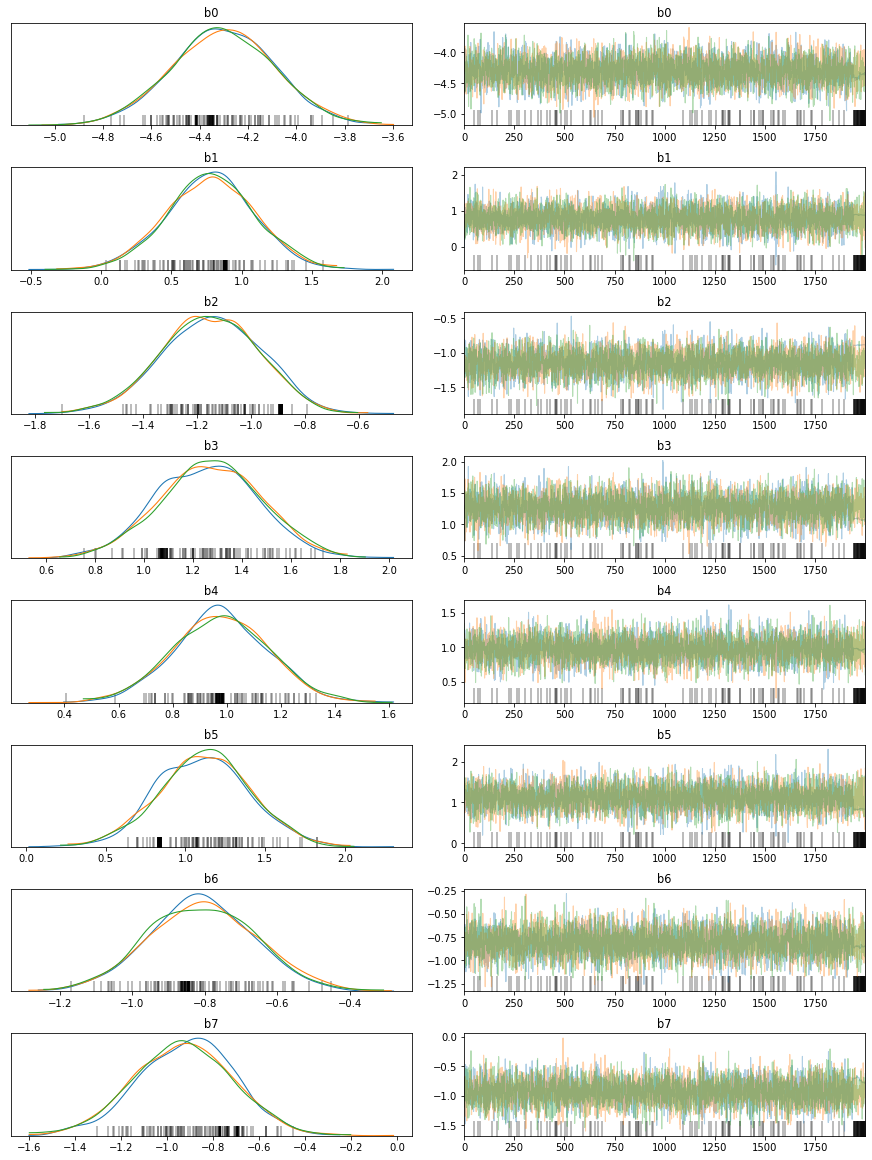

In [12]:
import arviz as az
az.plot_trace(trace, var_names=['b0', 'b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7']);


In [15]:
az.summary(trace, var_names=['b0', 'b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7'])

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
b0,-4.306,0.210,-4.696,-3.904,0.003,0.002,5974.0,5964.0,5971.0,5516.0,1.0
b1,0.776,0.310,0.180,1.346,0.004,0.003,7531.0,7268.0,7529.0,4785.0,1.0
b2,-1.151,0.181,-1.477,-0.807,0.003,0.002,4633.0,4633.0,4615.0,5658.0,1.0
b3,1.264,0.206,0.886,1.650,0.003,0.002,6028.0,5827.0,6025.0,5515.0,1.0
b4,0.976,0.174,0.650,1.297,0.002,0.002,6796.0,6684.0,6789.0,5363.0,1.0
b5,1.115,0.286,0.614,1.687,0.003,0.002,6860.0,6611.0,6853.0,5417.0,1.0
b6,-0.809,0.147,-1.102,-0.551,0.002,0.001,6559.0,6530.0,6555.0,5320.0,1.0
b7,-0.927,0.211,-1.308,-0.518,0.003,0.002,6093.0,6020.0,6098.0,5361.0,1.0


In [16]:
ppc = pm.sample_posterior_predictive(trace, samples=10000, model=model)


100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [02:36<00:00, 63.79it/s]


In [17]:
ppc_states = pd.DataFrame()
ppc_states['state'] = data_final['state'].values
ppc_states['actual_confirmed'] = data_final['Confirmed'].values
ppc_states['actual_death'] = data_final['Deaths'].values
ppc_states['5% HPD'] = np.percentile(ppc['obs'],5,axis=0)
ppc_states['median HPD'] = np.percentile(ppc['obs'],50,axis=0)
ppc_states['95% HPD'] = np.percentile(ppc['obs'],95,axis=0)
ppc_states['mortality_rate_of_confirmed'] = trace['theta'].mean(axis=0)
ppc_states['mortality_rate_sd'] = trace['theta'].std(axis=0)
status = []
for item in zip(ppc_states['actual_death'],ppc_states['5% HPD'],ppc_states['95% HPD']):
    status.append(item[0]>item[1] and item[0]<item[2])

In [18]:
ppc_states['prediction status'] = status

In [19]:
ppc_states.head(5)

,state,actual_confirmed,actual_death,5% HPD,median HPD,95% HPD,mortality_rate_of_confirmed,mortality_rate_sd,prediction status
0,Alabama,825,10,9.0,15.0,22.0,0.018050,0.001449,True
1,Arizona,919,17,16.0,24.0,32.0,0.025764,0.001737,True
2,Arkansas,426,6,3.0,6.0,11.0,0.015023,0.001266,True
3,California,5852,124,86.0,105.0,125.0,0.017957,0.001029,True
4,Colorado,2307,47,31.0,44.0,59.0,0.019362,0.002310,True


Below we can see posterior distribution for mortality rate in confirmed cases. Also I summarized this data in a following barplot.

C:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\arviz\plots\traceplot.py:218: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (48), generating only 40 plots
  UserWarning,


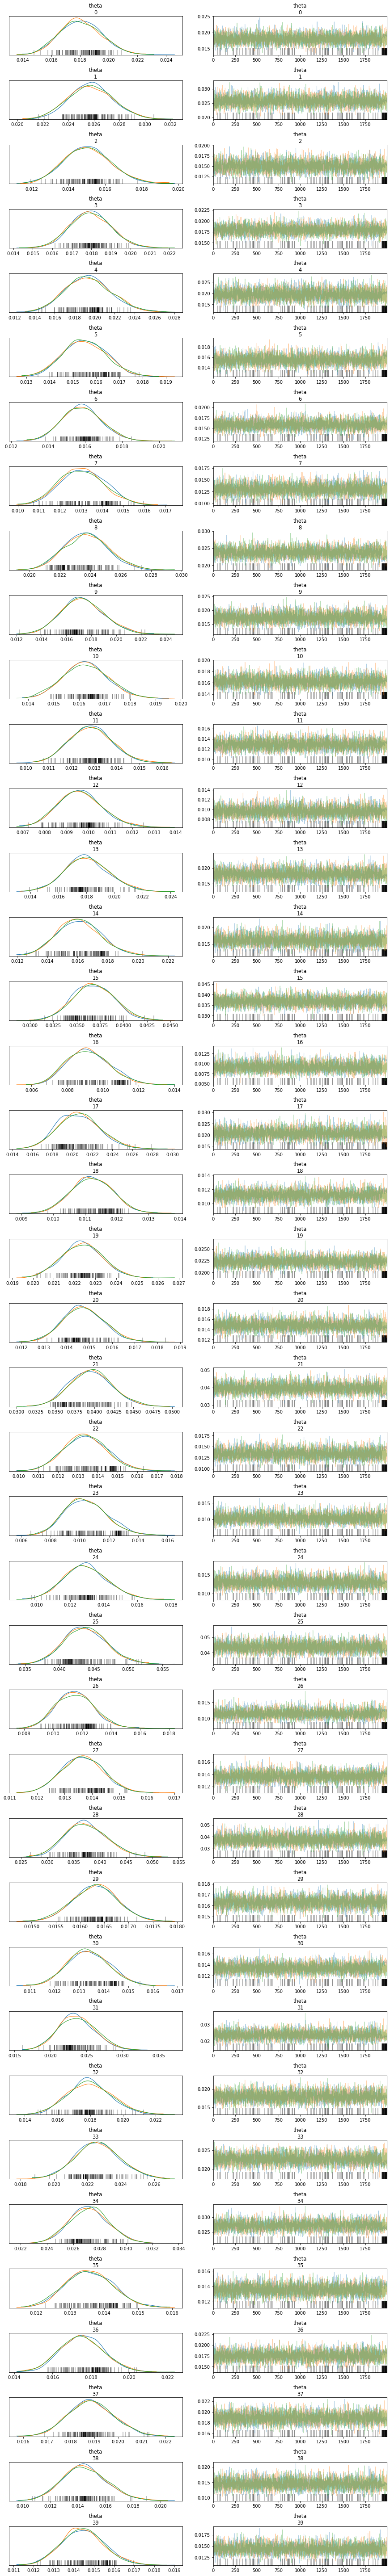

In [20]:
az.plot_trace(trace,var_names=('theta'));

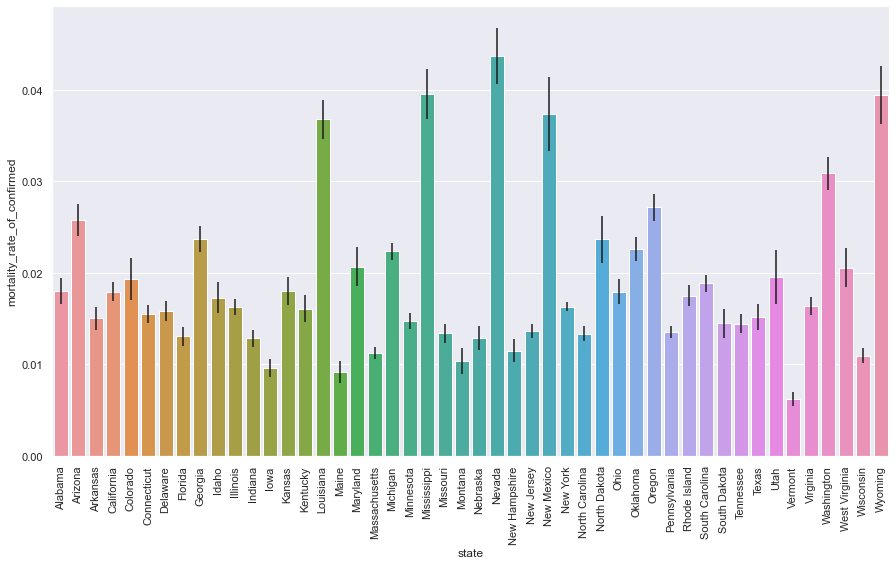

In [21]:
sns.set(rc={'figure.figsize':(15,8.27)})
ax = sns.barplot(x="state", y="mortality_rate_of_confirmed", yerr=ppc_states["mortality_rate_sd"], data=ppc_states)
ax.set_xticklabels(ppc_states['state'],rotation=90);


## Future work
* If we can have data for each individual we can make multilevel hierarchical model and this gives us better understanding of our problem. 
* A model with more predictive features and more recent data may help 
* If we can have total numbers of tests we can make similar model for confirmed cases to see how many of people may have corona given they have some symptoms.

## Concluding remark
I hope this model can be an inspiration for more useful works in future. Thank you for reviewing this work.
